In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num

#import iris
#import iris.iterate
#import iris.coords
#import iris.plot as iplt
import gsw

In [2]:
# load ROMS avg output

#for mm  in ['01','02','03','04','05','06','07','08','09','10','11','12']:
#    ds = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_21yr/ocean_avg_00' + mm + '.nc')
#    print(ds.variables["shflux"].shape)
#    shflux_tmp = np.nanmean(ds.variables["shflux"], axis=0)
#    ssflux_tmp = np.nanmean(ds.variables["ssflux"], axis=0)
    
    # concatanate monthly avgs into a yearly variable
#    if mm == '01':
#        shflux = shflux_tmp
#        ssflux = ssflux_tmp
#    elif mm == '02':
#        shflux = np.stack((shflux,shflux_tmp), axis=0)
#        ssflux = np.stack((ssflux,ssflux_tmp), axis=0)    
#    else:
#        shflux_tmp_4thdim = np.expand_dims(shflux_tmp, axis=0)
#        shflux = np.concatenate((shflux,shflux_tmp_4thdim), axis=0)
#        ssflux_tmp_4thdim = np.expand_dims(ssflux_tmp, axis=0)
#        ssflux = np.concatenate((ssflux,ssflux_tmp_4thdim), axis=0)
    

dg = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
#ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
#ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset


# read waom10_swflx file for (E-P fluxes)
dfw = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_swflux.nc")
dshf = xr.open_dataset("/scratch/project_2000339/boeiradi/waom10_frc/waom10extend_shflux_0.25Q.nc")



In [3]:
di = xr.open_dataset("/scratch/project_2000339/boeiradi/NSIDC/seaice_conc_monthly_sh_f13_200701_v03r01.nc")

ice_new = di.variables["seaice_conc_monthly_cdr"]
ice_lon = di.variables["longitude"]
ice_lat = di.variables["latitude"]

#salt = ds.variables["salt"]
projection = di.variables["projection"]
print(di)

ice_mm = np.empty((12,332,316))
count=0
for mm in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    di_tmp = xr.open_dataset("/scratch/project_2000339/boeiradi/NSIDC/seaice_conc_monthly_sh_f13_2007" + mm + "_v03r01.nc")

    ice_mm[count,:,:] = di_tmp.variables["seaice_conc_monthly_cdr"]
    if mm == '01':
        ice_lon = di_tmp.variables["longitude"]
        ice_lat = di_tmp.variables["latitude"]
        ice_xgrid = di_tmp.variables["xgrid"]
        ice_ygrid = di_tmp.variables["ygrid"]
    count = count + 1

/users/boeiradi/.local/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


<xarray.Dataset>
Dimensions:                                 (time: 1, xgrid: 316, ygrid: 332)
Coordinates:
  * time                                    (time) datetime64[ns] 2007-01-01
  * ygrid                                   (ygrid) float32 4337500.0 ... -39...
  * xgrid                                   (xgrid) float32 -3937500.0 ... 39...
    latitude                                (ygrid, xgrid) float64 ...
    longitude                               (ygrid, xgrid) float64 ...
Data variables:
    projection                              |S1 ...
    seaice_conc_monthly_cdr                 (time, ygrid, xgrid) float32 ...
    stdev_of_seaice_conc_monthly_cdr        (time, ygrid, xgrid) float32 ...
    melt_onset_day_seaice_conc_monthly_cdr  (time, ygrid, xgrid) float32 ...
    qa_of_seaice_conc_monthly_cdr           (time, ygrid, xgrid) float32 ...
    goddard_merged_seaice_conc_monthly      (time, ygrid, xgrid) float32 ...
    goddard_nt_seaice_conc_monthly          (time, ygrid, 

In [4]:
def lonlat_labels(ax):
    # latitude labels
    ax.text(120,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(120,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    # longitude labels
    ax.text(0,-66,'0$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    #ax.text(60,-53,'60$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(120,-53,'120$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    ax.text(-60,-48,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(-120,-48,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(180,-60,'180$^{\circ}$',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    return

proj = ccrs.SouthPolarStereo()

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)


def lonlat_labels_EastAntarctica(ax):
    # latitude labels
    ax.text(90,-80,'80$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(90,-70,'70$^{\circ}$S',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    # longitude labels
    ax.text(40,-75,'40$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    #ax.text(60,-53,'60$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(120,-53,'120$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray')
    #ax.text(-60,-48,'60$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    #ax.text(-120,-48,'120$^{\circ}$W',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    ax.text(140,-75,'140$^{\circ}$E',transform=ccrs.PlateCarree(),color='gray',fontsize=11)
    return



In [5]:
# plot some maps
fig_path='/users/boeiradi/COLD_project/postprocessing/figs/Storm_analyses/'

proj = ccrs.SouthPolarStereo()

HFmax=300
HFmin=-300
SFmin=-3.
SFmax=3.

In [6]:
months_start=[1,32,61,93,124,156,187,219,251,282,314,345]
months_end=[31,60,92,123,155,186,218,250,281,313,344,365]
print(months_start,months_end)

swf_range=np.arange(months_start[6]-1,months_end[6]-1,1)

print(swf_range)


[1, 32, 61, 93, 124, 156, 187, 219, 251, 282, 314, 345] [31, 60, 92, 123, 155, 186, 218, 250, 281, 313, 344, 365]
[186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216]


In [7]:
# read monthly files for specific events:

djun = xr.open_dataset("/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_21yr/ocean_avg_0006.nc") # daily file

print(djun)

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_psi: 559, eta_rho: 560, eta_u: 560, eta_v: 559, ocean_time: 6, s_rho: 31, s_w: 32, tracer: 2, xi_psi: 629, xi_rho: 630, xi_u: 629, xi_v: 630)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 ...
    y_rho          (eta_rho, xi_rho) float64 ...
    x_u            (eta_u, xi_u) float64 ...
    y_u            (eta_u, xi_u) float64 ...
    x_v            (eta_v, xi_v) float64 ...
    y_v            (eta_v, xi_v) float64 ...
    x_psi          (eta_psi, xi_psi) float64 ...
    y_psi          (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2027-06-04T14:00:00 ... 2027-0...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes         int32 ...
    ndtfast        

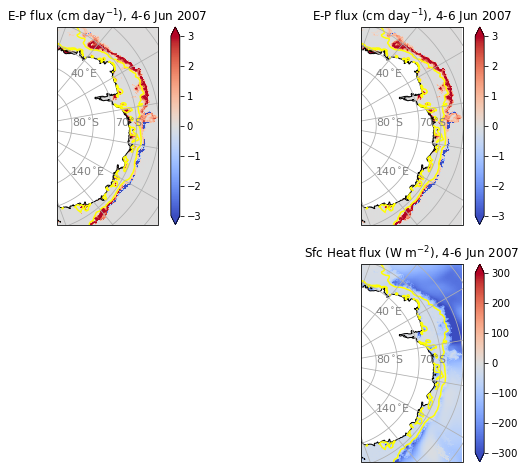

In [31]:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(224, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(158,160,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
plt.title('Sfc Heat flux (W m$^{-2}$), 4-6 Jun 2007')
ax3.gridlines()#draw_labels=True)
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
cbarh =fig.colorbar(cshf, extend='both')

name_fig="waom10extend_sfc_fluxes_maps_4-6.June.2007.png"
plt.savefig(fig_path + name_fig)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


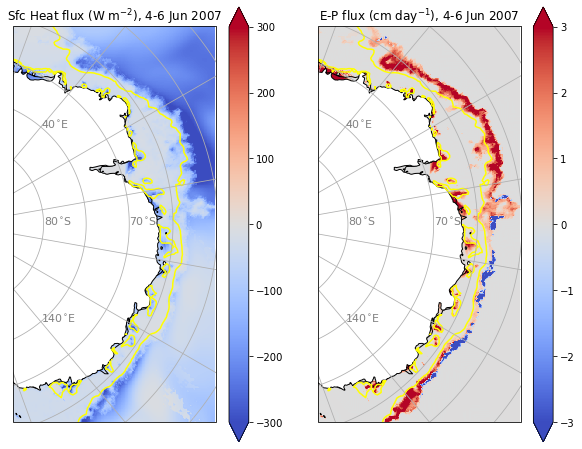

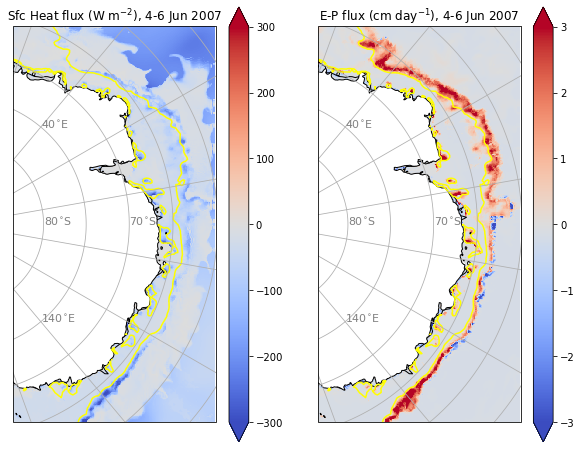

In [21]:
# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(158,160,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
plt.title('Sfc Heat flux (W m$^{-2}$), 4-6 Jun 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
cbarh =fig.colorbar(cshf, extend='both')

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(158,160,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
plt.title('E-P flux (cm day$^{-1}$), 4-6 Jun 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
cbarfw =fig.colorbar(cfw, extend='both')

#plt.tight_layout()
    
name_fig="waom10extend_sfc_fluxes_maps_4-6.June.2007.png"
plt.savefig(fig_path + name_fig)

# Using model diagnostic
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(djun.shflux.isel(ocean_time=0)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
plt.title('Sfc Heat flux (W m$^{-2}$), 4-6 Jun 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
cbarh =fig.colorbar(cshf, extend='both')

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = djun.ssflux.isel(ocean_time=0)
sss = np.squeeze(djun.salt.isel(s_rho=-1,ocean_time=0))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
plt.title('E-P flux (cm day$^{-1}$), 4-6 Jun 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
cbarfw =fig.colorbar(cfw, extend='both')

#plt.tight_layout()
    
name_fig="waom10extend_sfc_fluxes_model_maps_4-6.June.2007.png"
plt.savefig(fig_path + name_fig)





/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


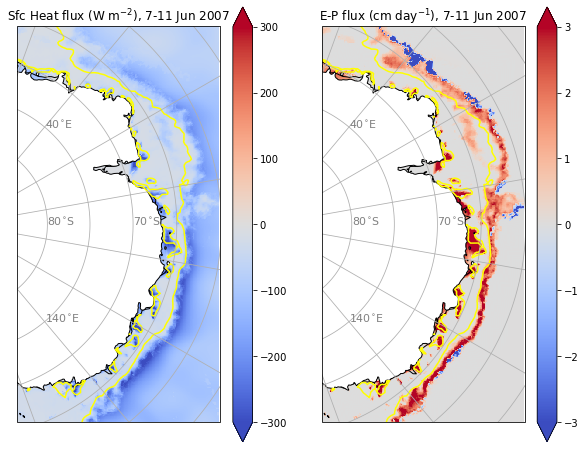

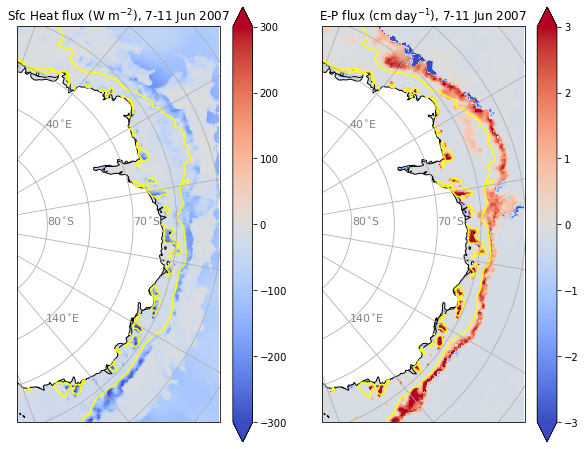

In [16]:
# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(161,165,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 7-11 Jun 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(161,165,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 7-11 Jun 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_7-11.June.2007.png"
plt.savefig(fig_path + name_fig)

# Model diag:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(djun.shflux.isel(ocean_time=1)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 7-11 Jun 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = djun.ssflux.isel(ocean_time=1)
sss = np.squeeze(djun.salt.isel(s_rho=-1,ocean_time=1))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 7-11 Jun 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_7-11.June.2007.png"
plt.savefig(fig_path + name_fig)




/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


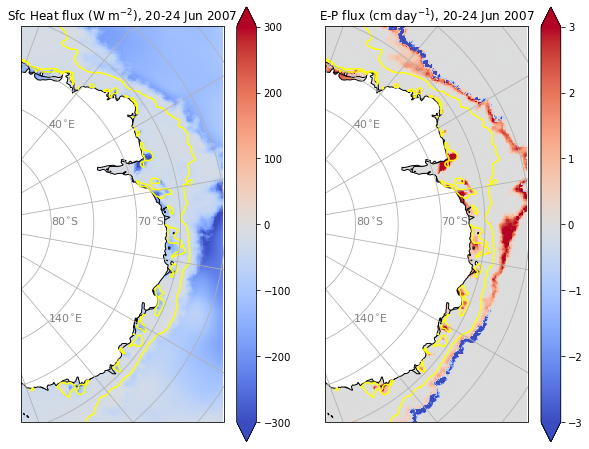

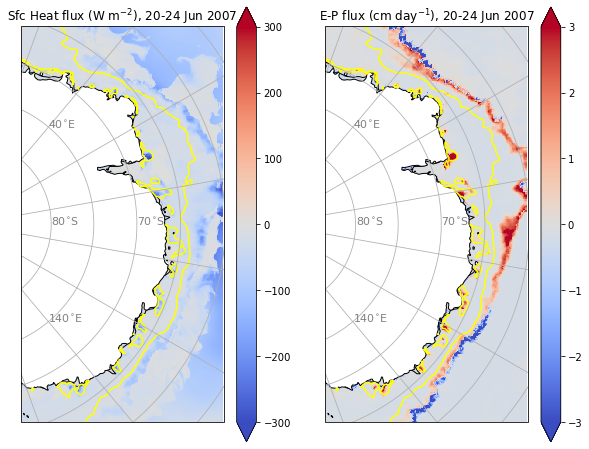

In [17]:
# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(174,178,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20-24 Jun 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())


ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(174,178,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20-24 Jun 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_20-24.June.2007.png"
plt.savefig(fig_path + name_fig)

# model diag:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(djun.shflux.isel(ocean_time=4)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20-24 Jun 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = djun.ssflux.isel(ocean_time=4)
sss = np.squeeze(djun.salt.isel(s_rho=-1,ocean_time=4))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[5,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20-24 Jun 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_20-24.June.2007.png"
plt.savefig(fig_path + name_fig)





In [18]:
djun.close()

djul = xr.open_dataset("/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_21yr/ocean_avg_0007.nc") # daily file



/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


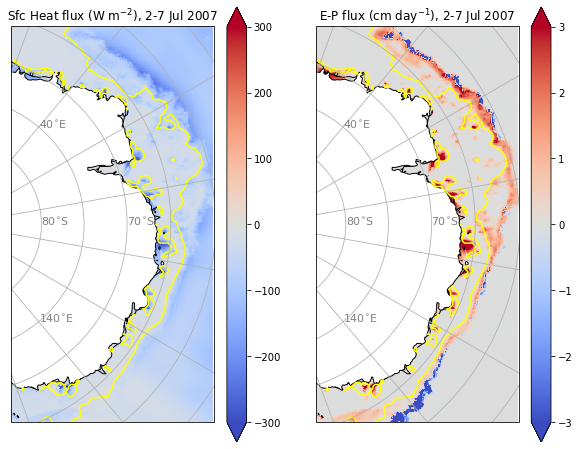

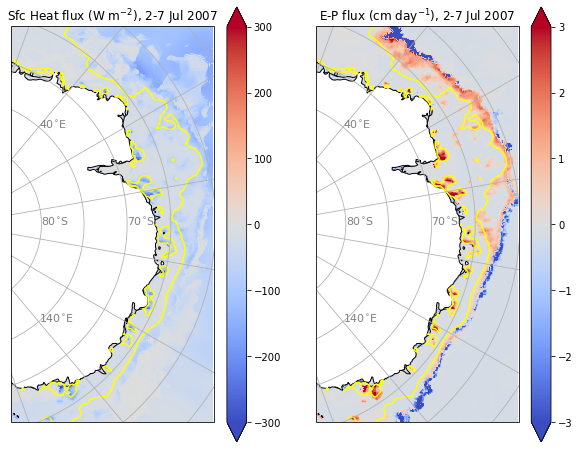

In [19]:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(187,192,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 2-7 Jul 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())


ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(187,192,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 2-7 Jul 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_2-7.July.2007.png"
plt.savefig(fig_path + name_fig)

# model diag
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(djul.shflux.isel(ocean_time=0)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 2-7 Jul 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = djul.ssflux.isel(ocean_time=0)
sss = np.squeeze(djul.salt.isel(s_rho=-1,ocean_time=0))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 2-7 Jul 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_2-7.July.2007.png"
plt.savefig(fig_path + name_fig)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


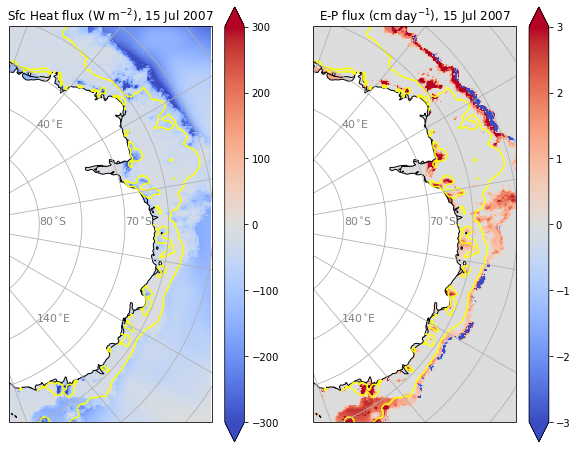

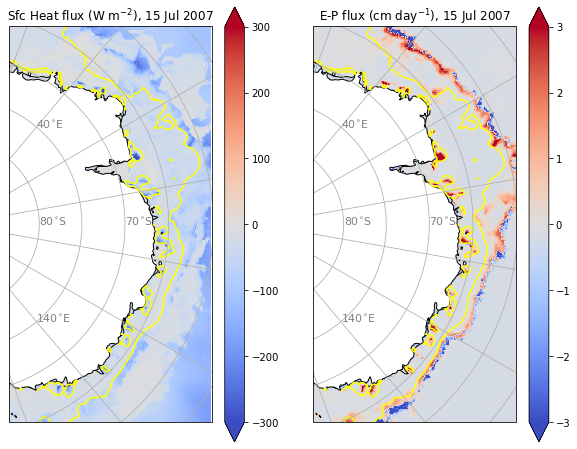

In [20]:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=200)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 15 Jul 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=200)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 15 Jul 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_15.July.2007.png"
plt.savefig(fig_path + name_fig)

# model diag:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(djul.shflux.isel(ocean_time=2)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 15 Jul 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = djul.ssflux.isel(ocean_time=2)
sss = np.squeeze(djul.salt.isel(s_rho=-1,ocean_time=2))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 15 Jul 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_15.July.2007.png"
plt.savefig(fig_path + name_fig)



/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


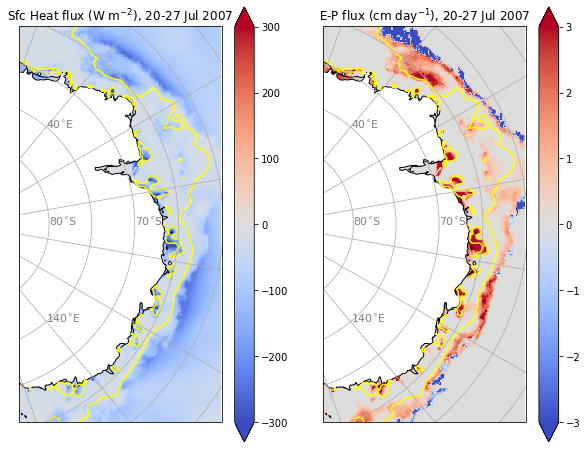

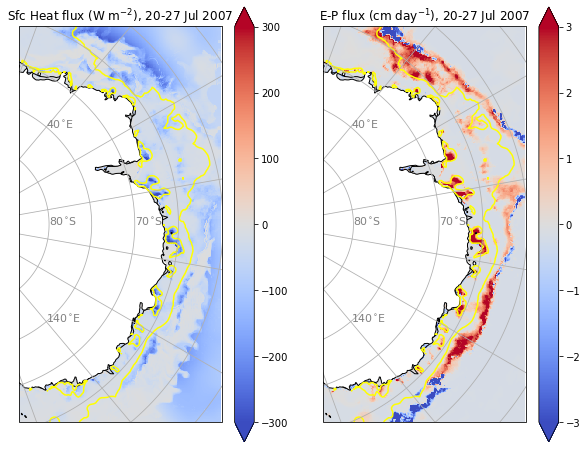

In [21]:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(205,212,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20-27 Jul 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(205,212,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20-27 Jul 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_20-27.July.2007.png"
plt.savefig(fig_path + name_fig)

# model diag:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(djul.shflux.isel(ocean_time=5)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20-27 Jul 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = djul.ssflux.isel(ocean_time=5)
sss = np.squeeze(djul.salt.isel(s_rho=-1,ocean_time=5))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[6,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20-27 Jul 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_20-27.July.2007.png"
plt.savefig(fig_path + name_fig)




In [22]:
djul.close()

daug = xr.open_dataset("/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_21yr/ocean_avg_0008.nc") # daily file



/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


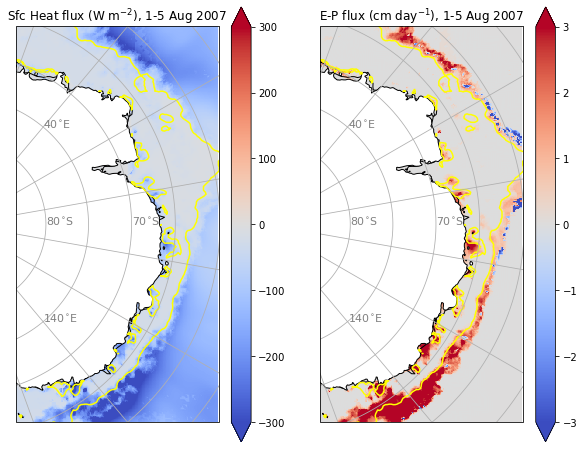

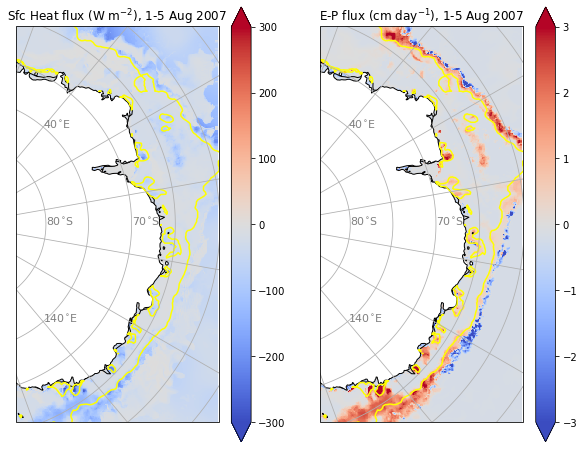

In [23]:
# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(218,222,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 1-5 Aug 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(218,222,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 1-5 Aug 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_1-5.August.2007.png"
plt.savefig(fig_path + name_fig)


# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(daug.shflux.isel(ocean_time=0)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 1-5 Aug 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = daug.ssflux.isel(ocean_time=0)
sss = np.squeeze(daug.salt.isel(s_rho=-1,ocean_time=0))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 1-5 Aug 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_1-5.August.2007.png"
plt.savefig(fig_path + name_fig)


/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


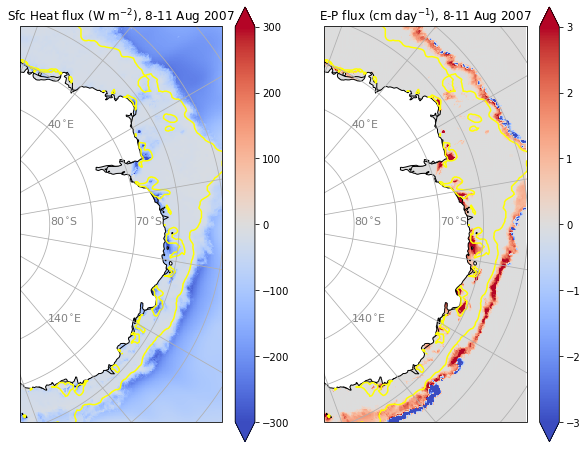

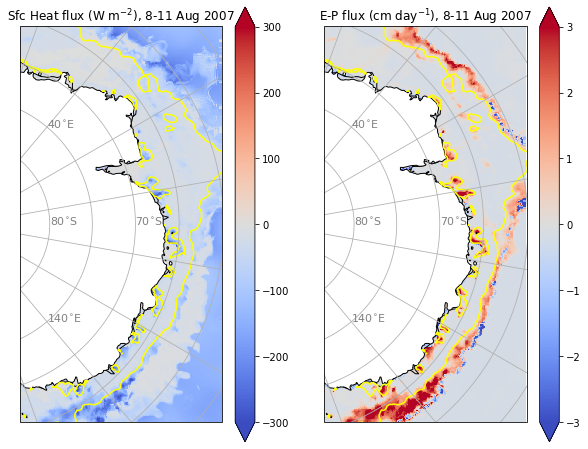

In [24]:
# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(225,228,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 8-11 Aug 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(225,228,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 8-11 Aug 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_8-11.August.2007.png"
plt.savefig(fig_path + name_fig)

# model diag
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(daug.shflux.isel(ocean_time=1)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 8-11 Aug 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())


#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = daug.ssflux.isel(ocean_time=1)
sss = np.squeeze(daug.salt.isel(s_rho=-1,ocean_time=1))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 8-11 Aug 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_8-11.August.2007.png"
plt.savefig(fig_path + name_fig)






/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


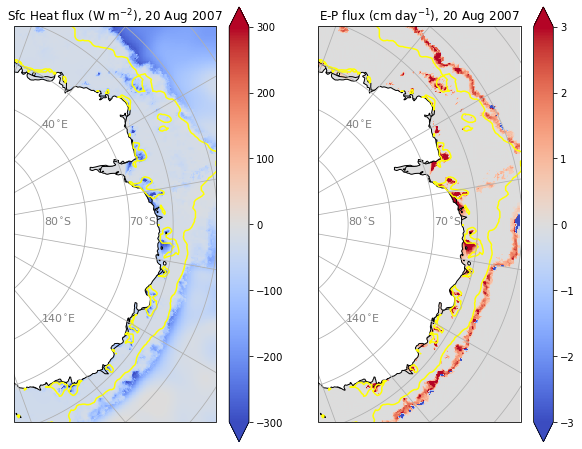

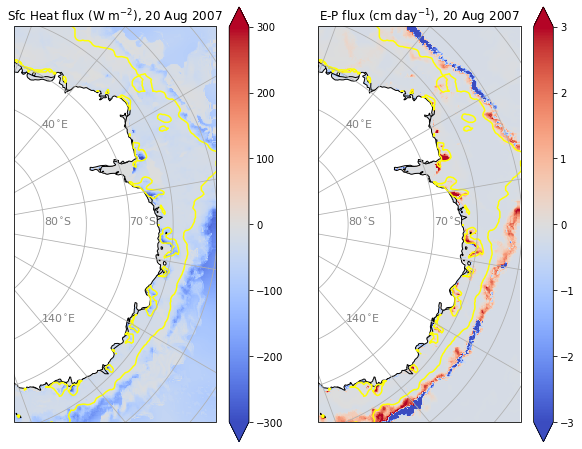

In [25]:
# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=237)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20 Aug 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=237)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20 Aug 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_maps_20.August.2007.png"
plt.savefig(fig_path + name_fig)

# model diag:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(daug.shflux.isel(ocean_time=3)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20 Aug 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())


#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = daug.ssflux.isel(ocean_time=3)
sss = np.squeeze(daug.salt.isel(s_rho=-1,ocean_time=3))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[7,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20 Aug 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())
    
name_fig="waom10extend_sfc_fluxes_model_maps_20.August.2007.png"
plt.savefig(fig_path + name_fig)



In [26]:
daug.close()

dsep = xr.open_dataset("/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_21yr/ocean_avg_0009.nc") # daily file



In [27]:
dsep.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 6)>
array(['2027-09-03T20:00:00.000000000', '2027-09-08T20:00:00.000000000',
       '2027-09-13T20:00:00.000000000', '2027-09-18T20:00:00.000000000',
       '2027-09-23T20:00:00.000000000', '2027-09-28T20:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2027-09-03T20:00:00 ... 2027-09-2...
Attributes:
    long_name:  averaged time since initialization
    field:      time, scalar, series

/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/scratch/project_2000339/boeiradi/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


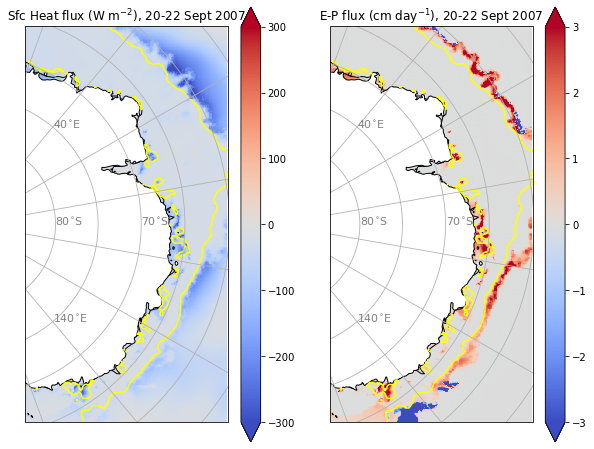

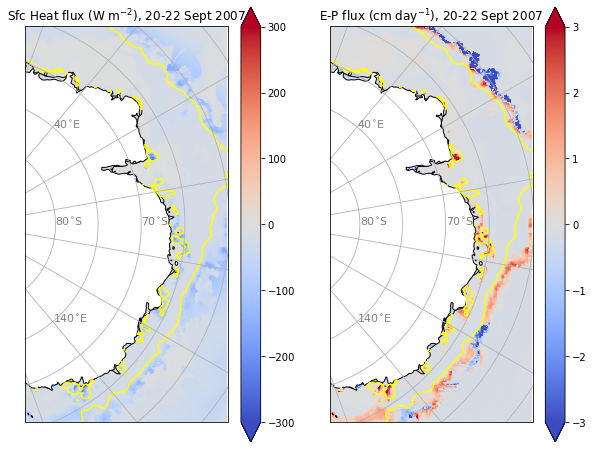

In [28]:
# plot some maps
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[8,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dshf.shflux.isel(shf_time=np.arange(269,271,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20-22 Sept 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[8,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dfw.swflux.isel(swf_time=np.arange(269,271,1))).mean(axis=0), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20-22 Sept 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#plt.tight_layout()
    
name_fig="waom10extend_sfc_fluxes_maps_20-22.September.2007.png"
plt.savefig(fig_path + name_fig)


# model diag:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(121, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[8,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cshf=plt.pcolormesh(lon_rho,lat_rho, np.squeeze(dsep.shflux.isel(ocean_time=5)), transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=HFmin, vmax=HFmax)
cbarh =fig.colorbar(cshf, extend='both')
plt.title('Sfc Heat flux (W m$^{-2}$), 20-22 Sept 2007')
ax3.gridlines()
ax3.coastlines(resolution='110m',color='black')
ax3.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax3)
#ax3.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())
ax3.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#convert salt (m.s-1) to fw fluxes (cm.day-1)
ssflx = dsep.ssflux.isel(ocean_time=5)
sss = np.squeeze(dsep.salt.isel(s_rho=-1,ocean_time=5))
model_swflx = np.divide(ssflx,sss)*8640000

ax4 = fig.add_subplot(122, projection=proj)
ci=plt.contour(ice_xgrid, ice_ygrid, np.squeeze(ice_mm[8,:,:]), levels=[.85],transform=ccrs.Stereographic(**kw),colors='yellow') #
cfw=plt.pcolormesh(lon_rho,lat_rho, model_swflx, transform=ccrs.PlateCarree(),cmap=plt.cm.coolwarm, vmin=SFmin, vmax=SFmax)
cbarfw =fig.colorbar(cfw, extend='both')
plt.title('E-P flux (cm day$^{-1}$), 20-22 Sept 2007')
ax4.gridlines()
ax4.coastlines(resolution='110m',color='black')
ax4.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='white')
lonlat_labels_EastAntarctica(ax4)
ax4.set_extent([40, 140, -80, -60], crs=ccrs.PlateCarree())

#plt.tight_layout()
    
name_fig="waom10extend_sfc_fluxes_model_maps_20-22.September.2007.png"
plt.savefig(fig_path + name_fig)








In [29]:
dsep.close()